Source:
https://github.com/niufir/yndx_ds_sample

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

    ## Подготовка данных

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pypl
from scipy.stats import spearmanr
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pandas import  DataFrame
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,recall_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# Чтение данных

In [3]:
def NullsStats(df: DataFrame) -> list[DataFrame]:
    df_na_sum = df.isna().sum()
    s_na_persent = df_na_sum / df.shape[0] * 100
    df_nuls = pd.DataFrame({'counts': df_na_sum, 'percent': s_na_persent})
    return [df_nuls, df_nuls.query('percent>0')]


path_dataset = r'Churn.csv'
if not os.path.exists(path_dataset):
    path_dataset = '/datasets/Churn.csv'

df = pd.read_csv(path_dataset, sep=',')

In [4]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [5]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
map_names = {"RowNumber":'row_number',"CustomerId":"customer_id",'Surname':'surname','CreditScore':'credit_score',
             'Geography':'geography','Gender':'gender','Age':'age','Tenure':'tenure','Balance':'balance',
             'NumOfProducts':'num_of_products','HasCrCard':'has_cr_card','IsActiveMember':'is_active_member',
             'EstimatedSalary':'estimated_salary','Exited':'exited'                                                                                    }
df = df.rename(columns=  map_names)
print(df.columns)

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


In [7]:
print(df.shape)
display( df.dtypes )

(10000, 14)


row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure              float64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [8]:
df.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
print( NullsStats( df )[0] )

                  counts  percent
row_number             0     0.00
customer_id            0     0.00
surname                0     0.00
credit_score           0     0.00
geography              0     0.00
gender                 0     0.00
age                    0     0.00
tenure               909     9.09
balance                0     0.00
num_of_products        0     0.00
has_cr_card            0     0.00
is_active_member       0     0.00
estimated_salary       0     0.00
exited                 0     0.00


In [10]:
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [11]:
df[df['tenure'].isna()].head(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Данные без пропусков находятся в диапазоне [0..10]
Пропуски в колонке tenure ( сколько лет человек является клиентом банка ) - не похоже, что забыли 0. Оставлю как есть - алгоритмы основанные на деревьях решений умеют работать с такими данными

In [12]:
print('count dublicates in data:', df.duplicated().sum())

count dublicates in data: 0


Размер данных - 10000 строк
Явных дубликатов в данных нет.
Пропусков мало - только 909 (9%) в колонке tenure ( сколько лет человек является клиентом банка ). Может стоит заменить на 0

In [13]:
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

## Предобарботка данных


In [14]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

конвентирую gender и geography через onehotencoder

In [15]:
df['gender'] = pd.get_dummies(df['gender'],drop_first=True).astype(int)

In [16]:
geo_dummy =pd.get_dummies(df['geography'],drop_first=True)
size_old = df.shape[0]
print(geo_dummy.shape)
df = pd.concat([df.drop('geography',axis=1),geo_dummy], axis=1)
map_names = {"Germany":'germany_dumm',"Spain":"spain_dumm"                                                                                  }
df = df.rename(columns=  map_names)
print(df.columns)
assert size_old == df.shape[0]

(10000, 2)
Index(['row_number', 'customer_id', 'surname', 'credit_score', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited', 'germany_dumm',
       'spain_dumm'],
      dtype='object')


In [17]:
df.shape

(10000, 15)

In [18]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

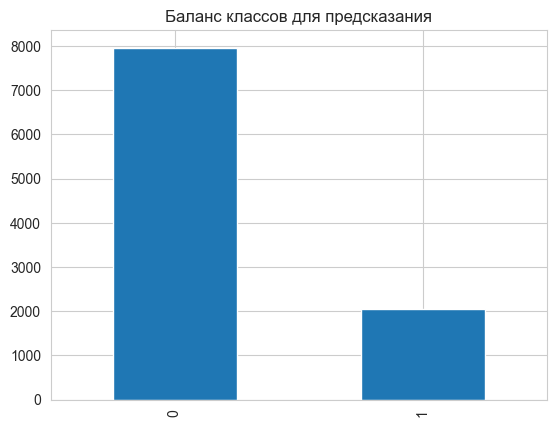

In [19]:
df['exited'].value_counts().plot(kind='bar',title='Баланс классов для предсказания');

выборка не сбалансирована - число уходов составляет 20% от всей выборки

In [20]:

colls4drop_tenure_train = ['row_number','customer_id','surname','tenure','exited']
feature4tenure_train = df[~df['tenure'].isna()].drop(colls4drop_tenure_train,axis=1)
target_tenure = df[~df['tenure'].isna()]['tenure']
    #.drop(colls4drop_tenure_train,axis=1)

mod_reg_tenure = RandomForestRegressor(random_state = 77)
mod_reg_tenure.fit(feature4tenure_train, target_tenure)
print( mean_absolute_error(target_tenure, mod_reg_tenure.predict(feature4tenure_train)) )




0.940661093389066


In [21]:
ix_nulls = df[df['tenure'].isna()].index
pred_tenue =  mod_reg_tenure.predict(df[df['tenure'].isna()].drop(colls4drop_tenure_train,axis=1))
lm_round = np.vectorize(lambda x: round(x))
pred_tenue = lm_round(pred_tenue)
df.loc[ix_nulls,'tenure'] = pred_tenue#mod_reg_tenure.predict(df[df['tenure'].isna()].drop(colls4drop_tenure_train,axis=1))

# df.loc[ix_nulls,'tenure'] = 0
assert df['tenure'].isna().sum() == 0

In [22]:
pred_tenue[:10]

array([6, 5, 6, 4, 5, 5, 5, 4, 4, 5])

In [23]:
display(df['tenure'].value_counts())

5.0     1406
6.0     1095
4.0     1068
2.0      953
1.0      952
3.0      942
7.0      941
8.0      933
9.0      882
10.0     446
0.0      382
Name: tenure, dtype: int64


- есть дисбаланс классов 7963 против 2037
- есть 10 признаков, которые будут использоваться для обучения моделей
- пропуски заполнил обученным случайным лесом


# Иследование моделей

## Разбивка датасета

In [24]:
target = df['exited']
featuer4drop = ['row_number','customer_id', 'surname','exited']
df_features = df.drop(featuer4drop, axis=1)
print(df_features.columns)


Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'germany_dumm',
       'spain_dumm'],
      dtype='object')


In [25]:
x_tmp, x_test, y_tmp, y_test = train_test_split(df_features, target, test_size=0.2, train_size=0.8,stratify=target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_tmp, y_tmp, test_size = 0.25, train_size =0.75, stratify=y_tmp,random_state=42)

print("размеры выборок для обучения:", x_train.shape, y_train.shape )
print("размеры выборок для валидации:", x_valid.shape, y_valid.shape)
print("размеры выборки для теста:", x_test.shape, y_test.shape)

размеры выборок для обучения: (6000, 11) (6000,)
размеры выборок для валидации: (2000, 11) (2000,)
размеры выборки для теста: (2000, 11) (2000,)


In [26]:
dummy_pred = [0]*len(y_valid)

## Логистическая регрессия

для логистической регресии важно привести диапазоны значений к одному диапазону.
сделаем   z- трансформацию

In [27]:
def print_scores(true_vals, pred_vals, pred_proba):
    print('recall:', recall_score(true_vals, pred_vals))
    print('accuracy:', accuracy_score(true_vals, pred_vals) )
    print('f1 score:', f1_score( true_vals, pred_vals ) )
    if pred_proba is not None:
        print('ROC-AUC', roc_auc_score(true_vals, pred_proba[:,1]))
    return

In [28]:
print_scores( y_valid, dummy_pred,None )

recall: 0.0
accuracy: 0.7965
f1 score: 0.0


In [29]:
df_features_lg = df_features.copy()
df_features_lg['tenure'] = df_features_lg['tenure'].fillna(0);
x_tmp, x_test, y_tmp, y_test = train_test_split(df_features_lg, target, test_size=0.2, train_size=0.8,stratify=target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_tmp, y_tmp, test_size = 0.25, train_size =0.75, stratify=y_tmp,random_state=42)

print("размеры выборок для обучения:", x_train.shape, y_train.shape )
print("размеры выборок для валидации:", x_valid.shape, y_valid.shape)
print("размеры выборки для теста:", x_test.shape, y_test.shape)

размеры выборок для обучения: (6000, 11) (6000,)
размеры выборок для валидации: (2000, 11) (2000,)
размеры выборки для теста: (2000, 11) (2000,)


In [30]:
std_scaler = StandardScaler()
sc_x_train = std_scaler.fit_transform(x_train)
sc_x_valid = std_scaler.transform(x_valid)
sc_x_test = std_scaler.transform(x_test)

In [31]:
model = LogisticRegression()
model.fit(sc_x_train, y_train)
pred = model.predict(sc_x_valid)
pred_proba = model.predict_proba(sc_x_valid)


In [32]:
print_scores(y_valid, pred,pred_proba )

recall: 0.21867321867321868
accuracy: 0.81
f1 score: 0.3189964157706094
ROC-AUC 0.7561706544757392


## Дерево решений

In [33]:
def searchBestDepth(fn_fabricMakeModel,x_train, y_train,x_valid,y_valid):
    top_model = None
    top_f1 = 0
    top_depth = 0
    for depth in range (1,20):
        clf = fn_fabricMakeModel(depth)
        clf.fit(x_train, y_train)
        pred_y = clf.predict(x_valid)
        f1 = f1_score(y_valid, pred_y)
        print('depth = ', depth, 'f1 = ',f1)
        if f1 > top_f1:
            top_depth = depth
            top_f1 = f1
            top_model = clf

    return top_model, top_f1, top_depth


In [34]:
top_model, top_f1, top_depth = searchBestDepth( lambda x:DecisionTreeClassifier(random_state=42, max_depth=x) , x_train, y_train,x_valid,y_valid)

depth =  1 f1 =  0.0
depth =  2 f1 =  0.5007112375533428
depth =  3 f1 =  0.38095238095238093
depth =  4 f1 =  0.46258503401360546
depth =  5 f1 =  0.475548060708263
depth =  6 f1 =  0.47018739352640543
depth =  7 f1 =  0.5625965996908809
depth =  8 f1 =  0.5341426403641882
depth =  9 f1 =  0.5449101796407186
depth =  10 f1 =  0.5534246575342466
depth =  11 f1 =  0.5389048991354467
depth =  12 f1 =  0.543448275862069
depth =  13 f1 =  0.5267379679144385
depth =  14 f1 =  0.5124835742444153
depth =  15 f1 =  0.5057766367137355
depth =  16 f1 =  0.48415716096324457
depth =  17 f1 =  0.5006289308176101
depth =  18 f1 =  0.5116851168511685
depth =  19 f1 =  0.4907521578298397


In [35]:
print('top depth:', top_depth)
print_scores(y_valid, top_model.predict( x_valid ),top_model.predict_proba( x_valid ) )

top depth: 7
recall: 0.44717444717444715
accuracy: 0.8585
f1 score: 0.5625965996908809
ROC-AUC 0.8317601114211285


## Случайный лес

In [36]:
def searchBestCountEstimators( fn_fabricMakeModel,  x_train, y_train, x_valid, y_valid, iter_range=range (10,200,10) ):
    top_nstm = 0
    top_f1 = 0
    top_model = None

    for nstm in iter_range:
        clf = fn_fabricMakeModel(nstm)
        f1,clf = trainTestModels(clf,
                                 x_train, y_train, x_valid, y_valid)
        print('n_estimators = ', nstm, ' f1=', f1)
        if f1>top_f1:
            top_f1 = f1
            top_nstm = nstm
            top_model = clf
    return top_model, top_f1, top_nstm


In [37]:
def trainTestModels(clf, x_train, y_train, x_valid, y_valid):
    clf.fit(x_train, y_train)
    pred_y = clf.predict(x_valid)
    f1 = f1_score(y_valid, pred_y)
    return f1, clf


In [88]:
top_model, top_f1, top_depth = searchBestDepth( lambda x:RandomForestClassifier(random_state=42, max_depth= x, n_estimators=15,criterion = 'entropy' ) , x_train, y_train,x_valid,y_valid)

depth =  1 f1 =  0.0
depth =  2 f1 =  0.07565011820330968
depth =  3 f1 =  0.22832980972515854
depth =  4 f1 =  0.3636363636363637
depth =  5 f1 =  0.4132841328413284
depth =  6 f1 =  0.4428571428571429
depth =  7 f1 =  0.4722222222222222
depth =  8 f1 =  0.5171849427168577
depth =  9 f1 =  0.5213114754098361
depth =  10 f1 =  0.5296950240770465
depth =  11 f1 =  0.5555555555555556
depth =  12 f1 =  0.5502318392581145
depth =  13 f1 =  0.5505443234836704
depth =  14 f1 =  0.5381026438569207
depth =  15 f1 =  0.5519379844961241
depth =  16 f1 =  0.564885496183206
depth =  17 f1 =  0.5306748466257669
depth =  18 f1 =  0.5476923076923077
depth =  19 f1 =  0.5753846153846154


In [89]:
print('top f1 score = ', top_f1)
print('top depth = ', top_depth)

top f1 score =  0.5753846153846154
top depth =  19


In [90]:
fn = lambda x:RandomForestClassifier(random_state=42, max_depth= top_depth, n_estimators=x, )
top_model, top_f1, top_nstm = searchBestCountEstimators( fn ,
                x_train, y_train, x_valid, y_valid)

top_model_random_forest = top_model

n_estimators =  10  f1= 0.5565749235474007
n_estimators =  20  f1= 0.5774436090225564
n_estimators =  30  f1= 0.5740458015267176
n_estimators =  40  f1= 0.5625965996908809
n_estimators =  50  f1= 0.5608628659476117
n_estimators =  60  f1= 0.5705521472392637
n_estimators =  70  f1= 0.5603715170278637
n_estimators =  80  f1= 0.5648148148148149
n_estimators =  90  f1= 0.5674418604651164
n_estimators =  100  f1= 0.5779816513761468
n_estimators =  110  f1= 0.5727411944869831
n_estimators =  120  f1= 0.5731895223420647
n_estimators =  130  f1= 0.5709876543209877
n_estimators =  140  f1= 0.576271186440678
n_estimators =  150  f1= 0.576271186440678
n_estimators =  160  f1= 0.5766871165644172
n_estimators =  170  f1= 0.5840978593272171
n_estimators =  180  f1= 0.5871559633027522
n_estimators =  190  f1= 0.5797546012269938


In [91]:
print('top n_estimators', top_nstm)
print('top f1', top_f1)

top n_estimators 180
top f1 0.5871559633027522


In [93]:
top_model, top_f1, top_nstm = searchBestCountEstimators( fn ,
                                                         x_train, y_train, x_valid, y_valid,
                                                         iter_range=range(164,178,2))



n_estimators =  164  f1= 0.5797546012269938
n_estimators =  166  f1= 0.5797546012269938
n_estimators =  168  f1= 0.5819295558958653
n_estimators =  170  f1= 0.5840978593272171
n_estimators =  172  f1= 0.5840978593272171
n_estimators =  174  f1= 0.5880551301684532
n_estimators =  176  f1= 0.5871559633027522


In [94]:
print('top n_estimators = ', top_nstm)
print_scores(y_valid, top_model.predict( x_valid ),top_model.predict_proba( x_valid ) )

top n_estimators =  174
recall: 0.47174447174447176
accuracy: 0.8655
f1 score: 0.5880551301684532
ROC-AUC 0.8568321788660771


Для моделей имеем следующие результаты
    логистическая регрессия - 0.319
    дерево решения -  0.563
    случайный лес -  0.579

Лучший результат у случайного леса - 0.579. Дерево решений имеет резульат чуть хуже -0.563. Самый плохой результат у линейной регрессии - 0.319

## Исследование моделей с балансировкой классов

### Создание upsampling данных

In [44]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled


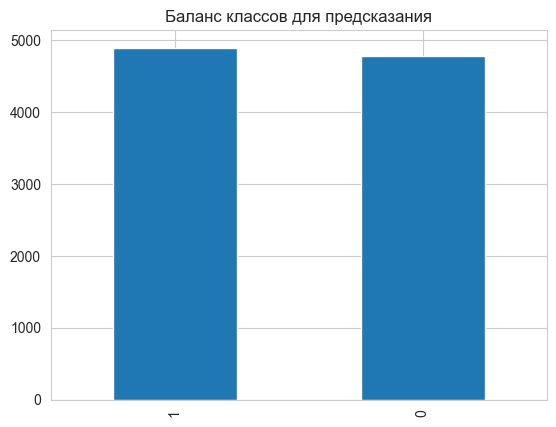

In [45]:
features_upsampled, target_upsampled = upsample(x_train, y_train,4)
target_upsampled.value_counts().plot(kind='bar',title='Баланс классов для предсказания');

### Cоздание Downsampling


In [46]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

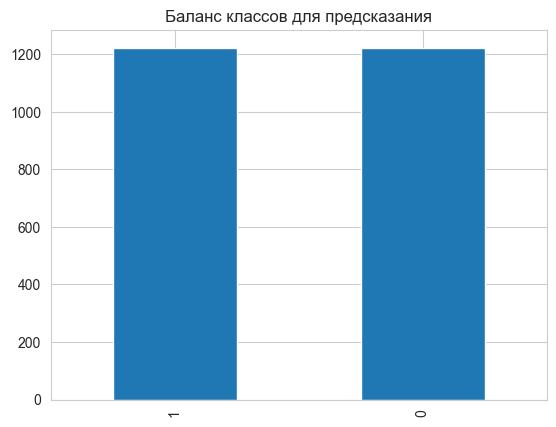

In [47]:
features_downsampled, target_downsampled = downsample(x_train, y_train, 0.256)
target_downsampled.value_counts().plot(kind='bar',title='Баланс классов для предсказания');

### Логистическая регрессия

In [48]:
model = LogisticRegression(class_weight = 'balanced')
model.fit(sc_x_train, y_train)
pred = model.predict(sc_x_valid)

print('balanced results')
print_scores(y_valid, pred,model.predict_proba(sc_x_valid))

balanced results
recall: 0.6633906633906634
accuracy: 0.708
f1 score: 0.4804270462633452
ROC-AUC 0.7607206590257438


In [49]:
model = LogisticRegression()
features_upsampled_cs = std_scaler.transform(features_upsampled)
model.fit(features_upsampled_cs, target_upsampled)
pred = model.predict(sc_x_valid)

print("upsample results:")
print_scores(y_valid, pred,model.predict_proba(sc_x_valid))

upsample results:
recall: 0.6732186732186732
accuracy: 0.702
f1 score: 0.47902097902097895
ROC-AUC 0.7607437946420996


In [50]:
model = LogisticRegression()
features_dwnsmpl_cs = std_scaler.transform(features_downsampled)
model.fit(features_dwnsmpl_cs, target_downsampled)
pred = model.predict(sc_x_valid)

print("downsample results:")
print_scores(y_valid, pred,model.predict_proba(sc_x_valid))

downsample results:
recall: 0.6584766584766585
accuracy: 0.713
f1 score: 0.4828828828828829
ROC-AUC 0.7618142024921686


Самый лучший результат достигнут для downsampling метода - думаю, это связано с тем, что модель переобучается на данных для 0 класса - при балансировке класса или при апсемплинге мы делаем копии экземпляров меньшего класса ( при балансировке - неявно ), при даунсемплинге выбираем небольшую часть данных из большего класса - этих данных достаточно для обучения модели.

### Дерево решений

#### балансировка классов

In [51]:
top_model, top_f1, top_depth = searchBestDepth( lambda x:DecisionTreeClassifier(random_state=42, max_depth=x, class_weight = 'balanced')
                                                , x_train, y_train,x_valid,y_valid)
top_model_decition_tree = top_model
top_f1_dt_balanced = top_f1

depth =  1 f1 =  0.4677023712183156
depth =  2 f1 =  0.4770346494762288
depth =  3 f1 =  0.4770346494762288
depth =  4 f1 =  0.5409836065573771
depth =  5 f1 =  0.5655813953488372
depth =  6 f1 =  0.588011417697431
depth =  7 f1 =  0.5692307692307692
depth =  8 f1 =  0.5823255813953488
depth =  9 f1 =  0.5781710914454278
depth =  10 f1 =  0.5622032288698956
depth =  11 f1 =  0.5587628865979382
depth =  12 f1 =  0.5493387589013226
depth =  13 f1 =  0.535059331175836
depth =  14 f1 =  0.5485327313769752
depth =  15 f1 =  0.5278725824800911
depth =  16 f1 =  0.5458768873403019
depth =  17 f1 =  0.535377358490566
depth =  18 f1 =  0.5308056872037915
depth =  19 f1 =  0.5452380952380952


In [52]:
print('top depth:', top_depth)
print_scores(y_valid, top_model.predict(x_valid), top_model.predict_proba(x_valid))

top depth: 6
recall: 0.7592137592137592
accuracy: 0.7835
f1 score: 0.588011417697431
ROC-AUC 0.8320446795023066


#### upsampling

In [53]:
top_model, top_f1, top_depth = searchBestDepth( lambda x:DecisionTreeClassifier(random_state=42, max_depth=x)
                                                , features_upsampled, target_upsampled,x_valid,y_valid)
top_f1_dt_upsampling = top_f1

depth =  1 f1 =  0.4677023712183156
depth =  2 f1 =  0.4770346494762288
depth =  3 f1 =  0.4770346494762288
depth =  4 f1 =  0.5409836065573771
depth =  5 f1 =  0.5655813953488372
depth =  6 f1 =  0.588011417697431
depth =  7 f1 =  0.5706051873198847
depth =  8 f1 =  0.5818521983161833
depth =  9 f1 =  0.5790513833992095
depth =  10 f1 =  0.5722433460076044
depth =  11 f1 =  0.5571725571725571
depth =  12 f1 =  0.5402650356778798
depth =  13 f1 =  0.5454545454545454
depth =  14 f1 =  0.5507900677200903
depth =  15 f1 =  0.5212399540757751
depth =  16 f1 =  0.5341176470588236
depth =  17 f1 =  0.5405405405405407
depth =  18 f1 =  0.5342789598108748
depth =  19 f1 =  0.5398335315101072


In [54]:
print('top depth:', top_depth)
print_scores(y_valid, top_model.predict(x_valid),top_model.predict_proba(x_valid))

top depth: 6
recall: 0.7592137592137592
accuracy: 0.7835
f1 score: 0.588011417697431
ROC-AUC 0.8320446795023066


f1 при балансировке классов и апсемплинге значения одинаковые - я пробовал изменить random_state - иногда лучшие скоры полностью совпадают

#### downsampling

In [55]:
top_model, top_f1, top_depth = searchBestDepth( lambda x:DecisionTreeClassifier(random_state=42, max_depth=x)
                                                , features_downsampled, target_downsampled,x_valid,y_valid)
top_f1_dt_downsampling = top_f1

depth =  1 f1 =  0.4677023712183156
depth =  2 f1 =  0.4770346494762288
depth =  3 f1 =  0.48862679022746414
depth =  4 f1 =  0.503003003003003
depth =  5 f1 =  0.5779092702169625
depth =  6 f1 =  0.5556544968833482
depth =  7 f1 =  0.5519779208831647
depth =  8 f1 =  0.5703493862134089
depth =  9 f1 =  0.531063829787234
depth =  10 f1 =  0.5241864555848724
depth =  11 f1 =  0.5132890365448505
depth =  12 f1 =  0.49823321554770306
depth =  13 f1 =  0.4885245901639344
depth =  14 f1 =  0.48854961832061056
depth =  15 f1 =  0.47634854771784235
depth =  16 f1 =  0.47293921731890093
depth =  17 f1 =  0.4726962457337884
depth =  18 f1 =  0.47372810675562965
depth =  19 f1 =  0.47372810675562965


In [56]:
print('top depth:', top_depth)
print_scores(y_valid, top_model.predict(x_valid),top_model.predict_proba(x_valid))

top depth: 5
recall: 0.7199017199017199
accuracy: 0.786
f1 score: 0.5779092702169625
ROC-AUC 0.8271892848164035


#### Работа с поргом


In [57]:
def calcF1Curve(pred_proba):
    x = []
    y = []
    top_x = 0;
    top_y = 0
    for edge in range(1,100):
        xpoint = (edge/100.0)
        cur_pred = pred_proba > xpoint
        cur_f1 = f1_score(y_valid, cur_pred)
        x.append(xpoint)
        y.append(cur_f1)
        if top_y<cur_f1:
            top_x = xpoint
            top_y = cur_f1
    return x, y, top_x, top_y

def drawRocCurve(y_valid, pred_proba):
    RocCurveDisplay.from_predictions(
        y_valid,
        pred_proba,
        name=f"1 vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC")
    plt.legend()
    plt.show()

    return

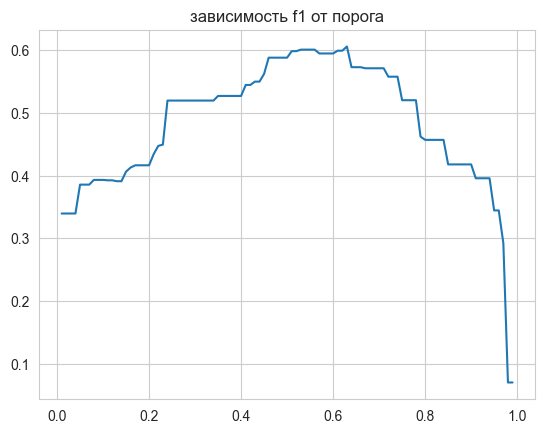

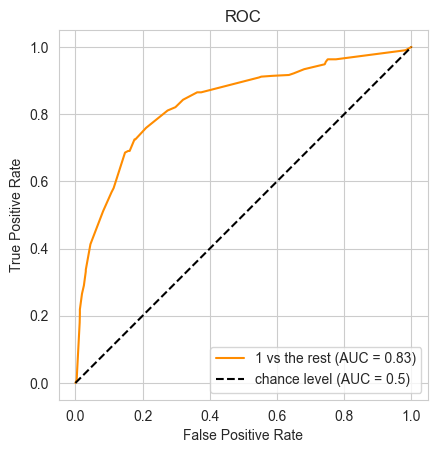

recall: 0.6855036855036855
accuracy: 0.8185
f1 score: 0.6058631921824104
ROC-AUC 0.8320446795023066


In [58]:
predict_proba = top_model_decition_tree.predict_proba(x_valid)[:, 1]
x, y, top_val, top_f1 = calcF1Curve(predict_proba)
plt.plot(x, y)
plt.title('зависимость f1 от порога')
plt.xlabel('')
plt.show()
drawRocCurve(y_valid, predict_proba)
print_scores(y_valid, predict_proba>top_val,top_model_decition_tree.predict_proba(x_valid))
top_f1_dt_range = top_f1

In [59]:
print('f1 balanced',top_f1_dt_balanced)
print('f1 upsampling',top_f1_dt_upsampling)
print('f1 downsampling',top_f1_dt_downsampling)
print('f1 range',top_f1_dt_range)

f1 balanced 0.588011417697431
f1 upsampling 0.588011417697431
f1 downsampling 0.5779092702169625
f1 range 0.6058631921824104


для дерева решений получились следующие результаты
    - балансировка - 0.588011417697431
    - апсемплинг -  0.588011417697431
    - downsampling -0.5779092702169625
    - работа с порогом - 0.6058631921824104

Балансировка и апсемлинг дали одинаковые результаты.  Downsampling хуже на >0.01. Лучше всего поднять метрику получилось использую сдвиг порога.


### случайный лес

#### Балансировка классов

In [69]:
# поиск оптимального значения max_depth
fn_fabric = lambda x:RandomForestClassifier(random_state=77, max_depth=x,n_estimators=15, class_weight='balanced',criterion = 'entropy')
top_model, top_f1, top_depth = searchBestDepth( fn_fabric
                                                , x_train, y_train,x_valid,y_valid)

depth =  1 f1 =  0.5103189493433395
depth =  2 f1 =  0.5204081632653061
depth =  3 f1 =  0.5429141716566867
depth =  4 f1 =  0.5629335976214074
depth =  5 f1 =  0.5737538148524923
depth =  6 f1 =  0.5804416403785488
depth =  7 f1 =  0.5883620689655172
depth =  8 f1 =  0.6008771929824562
depth =  9 f1 =  0.6329113924050633
depth =  10 f1 =  0.6105769230769231
depth =  11 f1 =  0.592020592020592
depth =  12 f1 =  0.6229508196721313
depth =  13 f1 =  0.5991792065663474
depth =  14 f1 =  0.5912305516265912
depth =  15 f1 =  0.5858585858585859
depth =  16 f1 =  0.5589123867069486
depth =  17 f1 =  0.573134328358209
depth =  18 f1 =  0.5641025641025641
depth =  19 f1 =  0.554364471669219


In [70]:
print('top depth:', top_depth)
print('top f1: ', top_f1)

top depth: 9
top f1:  0.6329113924050633


In [71]:
# поиск оптимального значения n_estimators
fn = lambda x:RandomForestClassifier(random_state=42, max_depth= top_depth, n_estimators=x,class_weight='balanced',criterion = 'entropy' )
top_model, top_f1, top_nstm = searchBestCountEstimators( fn ,
                                                         x_train, y_train, x_valid, y_valid)

top_model_rf_balanced = top_model
top_f1_balanced = top_f1

n_estimators =  10  f1= 0.6017897091722596
n_estimators =  20  f1= 0.617283950617284
n_estimators =  30  f1= 0.6279863481228669
n_estimators =  40  f1= 0.6188850967007963
n_estimators =  50  f1= 0.6272727272727272
n_estimators =  60  f1= 0.6285714285714287
n_estimators =  70  f1= 0.6275862068965518
n_estimators =  80  f1= 0.6229885057471264
n_estimators =  90  f1= 0.6260069044879172
n_estimators =  100  f1= 0.625
n_estimators =  110  f1= 0.6295005807200929
n_estimators =  120  f1= 0.6342592592592592
n_estimators =  130  f1= 0.6281755196304849
n_estimators =  140  f1= 0.6306098964326812
n_estimators =  150  f1= 0.6313364055299538
n_estimators =  160  f1= 0.6327944572748267
n_estimators =  170  f1= 0.6318234610917537
n_estimators =  180  f1= 0.6342592592592592
n_estimators =  190  f1= 0.6326767091541136


In [72]:
print('top nstm:', top_nstm)
print_scores(y_valid, top_model.predict(x_valid),top_model.predict_proba(x_valid))

top nstm: 120
recall: 0.6732186732186732
accuracy: 0.842
f1 score: 0.6342592592592592
ROC-AUC 0.858903587717147


#### upsampling

In [73]:
top_model, top_f1, top_depth = searchBestDepth( lambda x:RandomForestClassifier(random_state=42, max_depth=x,n_estimators=15,criterion = 'entropy')
                                                , features_upsampled, target_upsampled,x_valid,y_valid)

depth =  1 f1 =  0.48913043478260876
depth =  2 f1 =  0.5488372093023256
depth =  3 f1 =  0.5647969052224372
depth =  4 f1 =  0.559040590405904
depth =  5 f1 =  0.5845552297165201
depth =  6 f1 =  0.5797101449275363
depth =  7 f1 =  0.6019607843137255
depth =  8 f1 =  0.601036269430052
depth =  9 f1 =  0.609704641350211
depth =  10 f1 =  0.6137566137566137
depth =  11 f1 =  0.604494382022472
depth =  12 f1 =  0.6396396396396397
depth =  13 f1 =  0.6155632984901278
depth =  14 f1 =  0.6180469715698393
depth =  15 f1 =  0.6029776674937966
depth =  16 f1 =  0.5920398009950248
depth =  17 f1 =  0.6063694267515923
depth =  18 f1 =  0.598503740648379
depth =  19 f1 =  0.5922077922077922


In [74]:
print('top depth:', top_depth)
print('top f1: ', top_f1)

top depth: 12
top f1:  0.6396396396396397


In [77]:
fn = lambda x:RandomForestClassifier(random_state=42, max_depth= top_depth, n_estimators=x,criterion = 'entropy' )
top_model, top_f1, top_nstm = searchBestCountEstimators( fn ,
                                                         features_upsampled, target_upsampled, x_valid, y_valid)
top_f1_upsamplig = top_f1
top_model_rf_upsampling = top_model

n_estimators =  10  f1= 0.6270996640537515
n_estimators =  20  f1= 0.6382978723404256
n_estimators =  30  f1= 0.6303854875283446
n_estimators =  40  f1= 0.6442641946697567
n_estimators =  50  f1= 0.6306098964326812
n_estimators =  60  f1= 0.6268656716417911
n_estimators =  70  f1= 0.6291618828932263
n_estimators =  80  f1= 0.629757785467128
n_estimators =  90  f1= 0.6342592592592592
n_estimators =  100  f1= 0.6365740740740741
n_estimators =  110  f1= 0.6380510440835268
n_estimators =  120  f1= 0.6343713956170703
n_estimators =  130  f1= 0.6326767091541136
n_estimators =  140  f1= 0.6317016317016316
n_estimators =  150  f1= 0.6319444444444445
n_estimators =  160  f1= 0.6335260115606937
n_estimators =  170  f1= 0.6388888888888888
n_estimators =  180  f1= 0.6388888888888888
n_estimators =  190  f1= 0.6374133949191686


In [78]:
print('top nstm:', top_nstm)
print_scores(y_valid, top_model.predict(x_valid), top_model.predict_proba(x_valid))

top nstm: 40
recall: 0.683046683046683
accuracy: 0.8465
f1 score: 0.6442641946697567
ROC-AUC 0.8570897553948401


#### downsampling

In [79]:
fn = lambda x:RandomForestClassifier(random_state=42, max_depth= x, n_estimators=15,criterion = 'entropy' )
top_model, top_f1, top_depth = searchBestDepth( fn ,
                                                         features_downsampled, target_downsampled, x_valid, y_valid)


depth =  1 f1 =  0.49760765550239233
depth =  2 f1 =  0.5544554455445544
depth =  3 f1 =  0.5484496124031008
depth =  4 f1 =  0.5692742695570217
depth =  5 f1 =  0.5681818181818182
depth =  6 f1 =  0.5904404873477039
depth =  7 f1 =  0.5860113421550094
depth =  8 f1 =  0.5994291151284491
depth =  9 f1 =  0.5996204933586338
depth =  10 f1 =  0.5735567970204841
depth =  11 f1 =  0.5802238805970149
depth =  12 f1 =  0.5706106870229007
depth =  13 f1 =  0.5714285714285715
depth =  14 f1 =  0.5730550284629982
depth =  15 f1 =  0.5716928769657724
depth =  16 f1 =  0.5802816901408451
depth =  17 f1 =  0.5745257452574526
depth =  18 f1 =  0.563302752293578
depth =  19 f1 =  0.5682451253481894


In [80]:
print('top depth:', top_depth)
print('top f1: ', top_f1)

top depth: 9
top f1:  0.5996204933586338


In [81]:
fn = lambda x:RandomForestClassifier(random_state=42, max_depth= top_depth, n_estimators=x,criterion = 'entropy' )
top_model, top_f1, top_nstm = searchBestCountEstimators( fn ,
                                                         features_downsampled, target_downsampled, x_valid, y_valid,
                                                         #iter_range=range(12,17,1)
                                                         )

n_estimators =  10  f1= 0.5872259294566253
n_estimators =  20  f1= 0.5958646616541353
n_estimators =  30  f1= 0.5887939221272555
n_estimators =  40  f1= 0.5939278937381404
n_estimators =  50  f1= 0.6007604562737643
n_estimators =  60  f1= 0.6050096339113681
n_estimators =  70  f1= 0.5998071359691418
n_estimators =  80  f1= 0.5992292870905588
n_estimators =  90  f1= 0.6003861003861004
n_estimators =  100  f1= 0.596695821185617
n_estimators =  110  f1= 0.5990338164251208
n_estimators =  120  f1= 0.5988372093023255
n_estimators =  130  f1= 0.5988372093023255
n_estimators =  140  f1= 0.6034816247582204
n_estimators =  150  f1= 0.6032977691561591
n_estimators =  160  f1= 0.6015473887814312
n_estimators =  170  f1= 0.6013579049466538
n_estimators =  180  f1= 0.6046511627906976
n_estimators =  190  f1= 0.6023166023166023


In [82]:
print('top nstm:', top_nstm)
print('top f1: ', top_f1)

top nstm: 60
top f1:  0.6050096339113681


In [83]:
fn = lambda x:RandomForestClassifier(random_state=42, max_depth= top_depth, n_estimators=x,criterion = 'entropy' )
top_model, top_f1, top_nstm = searchBestCountEstimators( fn ,
                                                         features_downsampled, target_downsampled, x_valid, y_valid,
                                                         iter_range=range(12,25,1)
                                                         )
top_model_rf_downsampling = top_model
top_f1_downsampling = top_f1

n_estimators =  12  f1= 0.591254752851711
n_estimators =  13  f1= 0.5899143672692674
n_estimators =  14  f1= 0.5963912630579298
n_estimators =  15  f1= 0.5996204933586338
n_estimators =  16  f1= 0.5965909090909092
n_estimators =  17  f1= 0.592662276575729
n_estimators =  18  f1= 0.5859154929577465
n_estimators =  19  f1= 0.5903165735567969
n_estimators =  20  f1= 0.5958646616541353
n_estimators =  21  f1= 0.5956644674835061
n_estimators =  22  f1= 0.5941893158388003
n_estimators =  23  f1= 0.5932203389830508
n_estimators =  24  f1= 0.5883458646616542


In [84]:
print('top nstm:', top_nstm)
print_scores(y_valid, top_model.predict(x_valid), top_model.predict_proba(x_valid));

top nstm: 15
recall: 0.7764127764127764
accuracy: 0.789
f1 score: 0.5996204933586338
ROC-AUC 0.8481131362487294


#### Работа с порогом

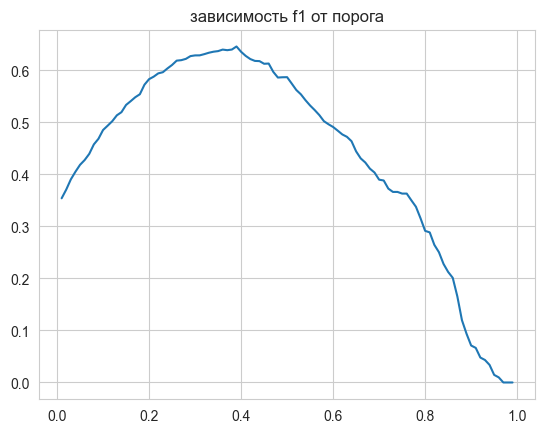

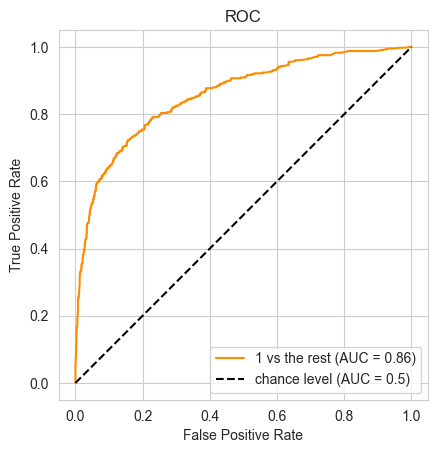

top nstm: 0.39
recall: 0.5945945945945946
accuracy: 0.8675
f1 score: 0.6461949265687583
ROC-AUC 0.8568198398706873


In [97]:
predict_proba = top_model_random_forest.predict_proba(x_valid)[:, 1]
x, y, top_val, top_f1_range_rf = calcF1Curve(predict_proba)
plt.plot(x, y)
plt.title('зависимость f1 от порога')
plt.xlabel('')
plt.show()
drawRocCurve(y_valid, predict_proba)
print('top nstm:', top_val)
print_scores(y_valid, predict_proba > top_val,top_model_random_forest.predict_proba(x_valid) );

In [98]:
print('f1 balanced',top_f1_balanced )
print('f1 upsampling',top_f1_upsamplig)
print('f1 downsampling',top_f1_downsampling)
print('f1 range ',top_f1_range_rf )


f1 balanced 0.6342592592592592
f1 upsampling 0.6442641946697567
f1 downsampling 0.5996204933586338
f1 range  0.6461949265687583


Лучший результат при сдвиге порога

 # Проверка лучшей модели на тестовой выборке

лучший результат на валидационноый выборке - для случайного леса со свдигом порога. Посчитаю скор на тестовой выборке

In [95]:
model = top_model_random_forest
pred_test = model.predict_proba(x_test)[:, 1]
pred_test = pred_test>top_val
print_scores(y_test,pred_test, model.predict_proba(x_test) )

recall: 0.6117936117936118
accuracy: 0.846
f1 score: 0.6178660049627792
ROC-AUC 0.8570774163994502


In [96]:
ft_importance_store= []
for ftname, ft_imp in zip (df_features.columns,top_model_random_forest.feature_importances_ ):
    ft_importance_store.append([ftname, ft_imp])
ft_importance_store.sort(key=lambda x:-x[1])

df_ft_imp = pd.DataFrame(ft_importance_store, columns=['name','imp'])

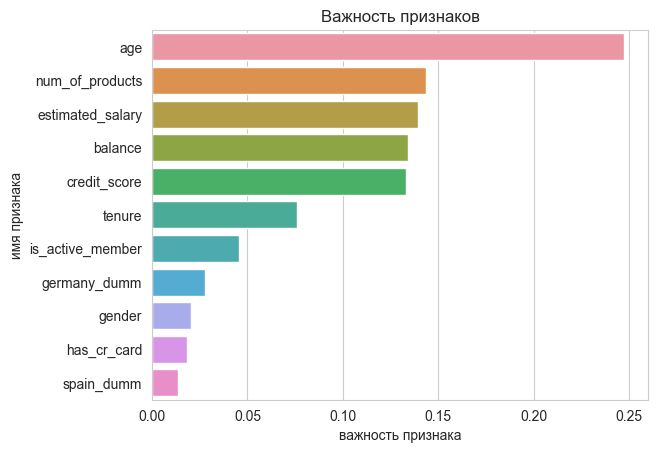

In [81]:
sns.barplot(data=df_ft_imp, x="imp", y="name").set(title="Важность признаков",xlabel="важность признака", ylabel='имя признака');

# Вывод

- В данных есть пропуски. Обучил регрерсси и заполнил пропуски - позволило повысить метрику, по сравнению с заполнением 0
- Лучшим алгоритмом оказался RandomFores
- Downsampling отработал только для логистической регресси
- нужно делать балансировку классов, для несбалансированной выборки. Так для
    для дерева решений
    -  0.5625965996908809
    с балансировкой классов
        - f1 balanced 0.588011417697431
        - f1 upsampling 0.588011417697431
        - f1 downsampling 0.5779092702169625
        - f1 range 0.6058631921824104

    для случайного леса
        - 0.5797546012269938
    с балансировкой классов
        - f1 balanced 0.6115342763873776
        - f1 upsampling 0.643956043956044
        - f1 downsampling 0.5965909090909092
        - f1 range  0.6533665835411472
        -
- Лучшай модель получилась при использовании алгоритма RandomForest со сдвигом порога
         на валидационной выборке - 0.6533
         на тестовой выборке - 0.6208
         разница между скорами большай - слегка переобучился видимо
- есть небольшая связь между f1 score и ROC-AUC. Обычно, когда f1 ростет то и ROC-AUC тоже ростет. Когда двигаем порог - связь теряется

            f1 score: 0.5625965996908809
            ROC-AUC 0.8317601114211285

            f1 score: 0.588011417697431
            ROC-AUC 0.8320446795023066

            f1 score: 0.588011417697431
            ROC-AUC 0.8320446795023066

            f1 score: 0.5779092702169625
            ROC-AUC 0.8271892848164035

            f1 score: 0.6058631921824104
            ROC-AUC 0.8320446795023066


            ----------
            f1 score: 0.5793528505392913
            ROC-AUC 0.8602732162054196

            f1 score: 0.6115342763873776
            ROC-AUC 0.8559052118374152

            f1 score: 0.643956043956044
            ROC-AUC 0.8620963027742689

            f1 score: 0.5965909090909092
            ROC-AUC 0.8452026757111504

            f1 score: 0.6533665835411472
            ROC-AUC 0.8602732162054196
